In [1]:
#Imports all data files from RSNA kaggle competition to google colab
for i in range (1,3):
  get_ipython().system('pip install -U pydicom')
  key={"username":"chonorat","key":"372dd2c0fad0556f067a3eb0452e8f77"}
  import json
  out_file = open("kaggle.json",'w+') 
  json.dump(key,out_file) 
  get_ipython().system('pip install -U -q kaggle')
  get_ipython().system('mkdir -p ~/.kaggle')
  get_ipython().system('cp kaggle.json ~/.kaggle/')
  get_ipython().system('kaggle datasets list')
get_ipython().system('kaggle competitions download -c rsna-pneumonia-detection-challenge')
get_ipython().system('unzip stage_2_train_images.zip -d train_images')
get_ipython().system('unzip stage_2_test_images.zip -d test_images')
get_ipython().system('unzip stage_2_detailed_class_info.csv.zip ')
get_ipython().system('unzip stage_2_train_labels.csv.zip')

import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
import seaborn as sns

Requirement already up-to-date: pydicom in /usr/local/lib/python3.6/dist-packages (1.2.2)
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 119, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 160, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.
Requirement already up-to-date: pydicom in /usr/local/lib/python3.6/dist-packages (1.2.2)
ref                                                          title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------

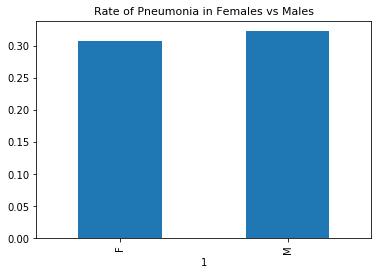

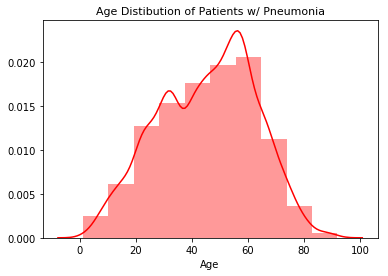

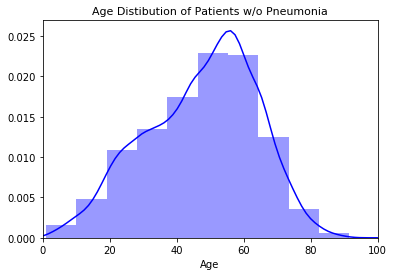

In [2]:

#Extract patientId,Age,Sex from DICOM images.
image_list=[]
age_sex_name=[]
for filename in glob.glob("/content/train_images/*.dcm"):
    ds=pydicom.read_file(filename)
    image_list.append(ds)
    age_sex_name.append([ds[0x010, 0x1010].value,ds[0x010, 0x040].value,str(ds[0x010, 0x010].value)])   
images=pd.DataFrame(np.array(age_sex_name)).T
images=pd.DataFrame(images)
images=images.T
images = images.rename(columns={2: 'patientId'})
images['Has_image']=1

#merge csv data
labels=pd.read_csv("/content/stage_2_train_labels.csv")
classinfo=pd.read_csv("/content/stage_2_detailed_class_info.csv")
info = pd.merge(classinfo, images, how='inner', on='patientId')
info1 =pd.concat([info.drop("patientId",1), labels], 1)

#Plot rates of pneumonia between sexes.  No meaningful differences.
info1['Target'].groupby(info1[1]).mean().plot(kind='bar')
plt.title ('Rate of Pneumonia in Females vs Males', fontsize=11)
plt.show()

#Plot histogram of ages between paties w/ and w/o pneumonia.  The two groups appear to have the same distribution.
#Again there appears to be no meanngful difference.  Sex and Age will not be factors in the model.
info1["Age"]=info1[0].astype(float)
sns.distplot(info1.loc[info1['Target'] == 1].Age,color="red",bins=10)
plt.title ('Age Distibution of Patients w/ Pneumonia', fontsize=11)
plt.show()
sns.distplot(info1.loc[info1['Target'] == 0].Age,color='blue',bins=17)
axes = plt.gca()
axes.set_xlim([0,100])
plt.title ('Age Distibution of Patients w/o Pneumonia', fontsize=11)
plt.show()

In [0]:
# Create list of all pneumonia bounding boxes for all images.  
#Only includes patients with pneumonia.
pneumonia_locations = {}
for i in range(1,len(info1)):
  filename = info1.patientId[i]
  location = info1.x[i],info1.y[i],info1.width[i],info1.height[i]
  pneumonia = info1.Target[i]
  if pneumonia == 1:
    location = [int(float(i)) for i in location]
    if filename in pneumonia_locations:
      pneumonia_locations[filename].append(location)
    else:
      pneumonia_locations[filename] = [location]
                
 

# Splits train/validation images
folder = '/content/train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
n_train_samples = len(filenames) - n_valid_samples


In [0]:
df = pd.read_csv('/content/stage_2_train_labels.csv')
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '/content/train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed
parsed = parse_data(df)

In [0]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    minx = 1000
    maxx = 0
    miny = 1000
    maxy = 0
    for box in data['boxes']:
        box = [int(b) for b in box]
        y1, x1, height, width = box
        y2 = y1 + height
        x2 = x1 + width
        if x1<minx:
            minx = x1
        if x2>maxx:
            maxx = x2
        if y1<miny:
            miny = y1
        if y2>maxy:
            maxy = y2
        
    minx -= 150
    maxx += 150
    miny -= 150
    maxy += 150
    for box in data['boxes']:  
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
    imc = im[miny:maxy, minx:maxx]

    pl.imshow(imc, cmap=pl.cm.gist_gray)
    pl.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [0]:
#create cropping function.  Cropping should improve the runtime and accuracy of the network.
def fixcrop(im):
  #Resulting Resolution should be 800x800
    im = im[112:(im.shape[0]-112),112:(im.shape[1]-112)]     
    return im

1.0
1.0


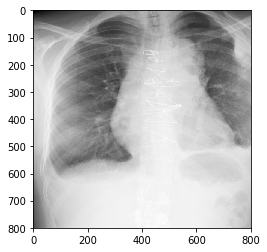

In [7]:
#Plot a sample cropped image.
#The cropped image reduced the total amount of pixels by more than 8%.
import matplotlib.pyplot as pl
img = pydicom.dcmread(os.path.join('/content/train_images', filenames[5])).pixel_array
pl.imshow(img, cmap=pl.cm.gist_gray)
print(img.shape[0]/img.shape[1])
im1 = fixcrop(img)
pl.imshow(im1, cmap=pl.cm.gist_gray)
print(im1.shape[0]/im1.shape[1])

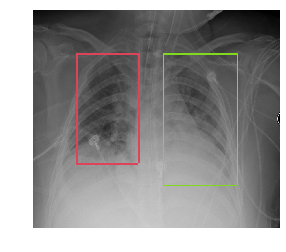

In [8]:
#Plot a cropped image with the pneumonia bounding box.
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

In [0]:
#Generator samples batches from image directory, resizes the image, crops the image, and creates an image mask.
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=16, image_size=400, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.6:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = fixcrop(img)
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = fixcrop(msk)        
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.55

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = fixcrop(img)
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
# Choice of BN->RELU is due to experimental evidence of outperforming RELU->BN
# https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/
# Normalize, Cut Negatives, then downsample by a factor of 2
def create_downsample(channels, inputs):
    # This BatchNorm normalizes the pixel around a mean of 0, and std of 1
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    # LeakyRELU is a RELU with an added feature of allowing for negative values
    # to contribute to gradient by a factor of alpha. Since alpha is 0, this is
    # just a regular RELU
    x = keras.layers.LeakyReLU(0)(x)
    # This confolution operation simply takes a multi-channel image and does a 
    # dot product of the channels for each pixel. Image size remains unchanged.
    # DICOM images are 1 channel, so this layer has no effect.
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    # This layer halves the hight and width by bunching up every square of 4
    # pixels, and letting only the pixel with the highest value survive to the
    # next layer.
    x = keras.layers.MaxPool2D((2, 2))(x)
    return x

# The convolution branch will have 2 cascaded convolution operations

def create_resblock(channels, inputs):
    # As before, normalize and then cut the negatives
    x = keras.layers.BatchNormalization(momentum=0.95)(inputs)   
    x = keras.layers.LeakyReLU(0)(x)
    # 3x3 kernel is convolved with the previous layer while maintaining size
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    # Normalize, Cut negatives, and convolve again while maintaining size
    x = keras.layers.BatchNormalization(momentum=0.95)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    # Output the result of the 2 convs while also passing the block's input
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=3):
    # Input image size of model must match actual input images
    inputs = keras.Input(shape=(input_size, input_size, 1))
    # The first operation flattens layers and brings out interesting features
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # Residual blocks form a pattern as network gets deeper
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # Output goes through BN->RELU 
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    # Finally goes through a signmoid function to assign a certainty for
    # each of the outputs
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
  
  
# Intersection over union is a measure of how accurately a bounding box represents
# its target. Intersection is the part of the estimated box that is correct.
# Union is the portion of the estimated box outside the correct region. The goal
# of an IoU loss function is to maximize this value such that the estimated
# bounding box contains the correct region while aiming to restrict the box 
# tightly to the target.
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score



# Specify the network.  Selected the optimizer 'Adam' and the loss function is Intersection over Union.
model = create_network(input_size=400, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_loss,
              metrics=['accuracy'])

# create train and validation generators
folder = '/content/train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=400, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=400, shuffle=False, predict=False)


In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 400, 400, 1)  0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 400, 400, 32) 288         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_126 (Bat (None, 400, 400, 32) 128         conv2d_132[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_126 (LeakyReLU)     (None, 400, 400, 32) 0           batch_normalization_v1_126[0][0] 
__________________________________________________________________________________________________
conv2d_133

In [31]:
#Fit the model to the training data and validate on the validation set. The network runs 25 epochs.
history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=25, shuffle=True)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

KeyboardInterrupt: ignored

In [0]:
#The model is now validated on the validation data.  Red bounding boxes are the true bounding boxes.
#Blue bounding boxes are the predicted bounding boxes.
#Predicitions are only displayed for the first batch.
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = pl.subplots(4, 4, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0],cmap=pl.cm.gist_gray)
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y+30
            width = x2 - x+30
            axarr[axidx].add_patch(patches.Rectangle((x-14,y-14),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    pl.show()
    # only plot one batch
    break

In [0]:
# load/shuffle test data
folder = '/content/test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# generate test data, this time predict is set to True
test_gen = generator(folder, test_filenames, None, batch_size=16, image_size=256, shuffle=False,predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('/content/Predictions.csv')
